In [1]:
%pylab inline

import numpy as np
import scipy.stats as stats
import pymc3 as pm
from theano import shared
import theano
import theano.tensor as tt
floatX = "float32"

%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# PyMC3 Modeling tips and heuristic
A walkthrough of implementing a Conditional Autoregressive (CAR) model in `PyMC3`, with `WinBugs`/`PyMC2` and `STAN` code as references.

* Notebook Written by [Junpeng Lao](https://www.github.com/junpenglao/), inspired by `PyMC3` [issue#2022](https://github.com/pymc-devs/pymc3/issues/2022), [issue#2066](https://github.com/pymc-devs/pymc3/issues/2066) and [comments](https://github.com/pymc-devs/pymc3/issues/2066#issuecomment-296397012). I would like to thank [@denadai2](https://github.com/denadai2), [@aseyboldt](https://github.com/aseyboldt), and [@twiecki](https://github.com/twiecki) for the helpful discussion.

As a probabilistic language, there are some fundamental differences between `PyMC3` and other alternatives such as `WinBugs`, `JAGS`, and `STAN`. In this notebook, I will summarise some heuristics and intuition I got over the past two years using `PyMC3`. I will outline some thinking process of how I approach a modelling problem using `PyMC3`, and how thinking in linear algebra solves most of the programming problem. I hope this notebook will shed some light into the design and feature of `PyMC3`, and similar language built on linear algebra package with a static world view (e.g., Edward, which is based on Tensorflow).  


For more resources comparing between PyMC3 codes and other probabilistic languages:
* [PyMC3 port of "Doing Bayesian Data Analysis" - PyMC3 vs WinBugs/JAGS/STAN](https://github.com/aloctavodia/Doing_bayesian_data_analysis)
* [PyMC3 port of "Bayesian Cognitive Modeling" - PyMC3 vs WinBugs/JAGS/STAN](https://github.com/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3)
* [[WIP] PyMC3 port of "Statistical Rethinking" - PyMC3 vs STAN](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3)

## Background information
Supposed we want to implement a [Conditional Autoregressive (CAR) model](http://www.statsref.com/HTML/index.html?car_models.html) with some reference codes in [WinBugs/PyMC2](http://glau.ca/?p=340) and [STAN](http://mc-stan.org/documentation/case-studies/mbjoseph-CARStan.html).  
For the sake of brevity, I will not go into the details of the CAR model. The essential idea of this kind model is autocorrelation, which is informally speaking "correlation with itself". In a CAR model, the probability of values estimated at any given location $y_i$ are conditional on some neighboring values $y_j, _{j \neq i}$ (in another word, correlated/covariated with these values):  

$$y_i \mid y_j, j \neq i \sim \mathcal{N}(\alpha \sum_{j = 1}^n b_{ij} y_j, \sigma_i^{2})$$

where $\sigma_i^{2}$ is a spatially varying covariance parameter, and $b_{ii} = 0$. 

Here we will demonstrate the implementation of a CAR model using the canonical example: the lip cancer risk data in Scotland between 1975 and 1980. The original data is from (Kemp et al. 1985). This data set includes observed lip cancer case counts at 56 spatial units in Scotland, with the expected number of cases as intercept, and an area-specific continuous variable coded for the proportion of the population employed in agriculture, fishing, or forestry (AFF). We want to model how lip cancer rates (`O` below) relate to AFF (`aff` below), as exposure to sunlight is a risk factor.

$$O_i \sim \mathcal{Poisson}(\text{exp}(\beta_0 + \beta_1*aff + \phi_i + \log(\text{E}_i)))$$
$$\phi_i \mid \phi_j, j \neq i \sim \mathcal{N}(\alpha \sum_{j = 1}^n b_{ij} \phi_j, \sigma_i^{2})$$

Setting up the data:

In [2]:
county = np.array(["skye_lochalsh", "banff_buchan", "caithness,berwickshire", "ross_cromarty", 
                   "orkney", "moray", "shetland", "lochaber", "gordon", "western_isles", 
                   "sutherland", "nairn", "wigtown", "NE.fife", "kincardine", "badenoch", 
                   "ettrick", "inverness", "roxburgh", "angus", "aberdeen", "argyll_bute", 
                   "clydesdale", "kirkcaldy", "dunfermline", "nithsdale", "east_lothian", 
                   "perth_kinross", "west_lothian", "cumnock_doon", "stewartry", "midlothian", 
                   "stirling", "kyle_carrick", "inverclyde", "cunninghame", "monklands", 
                   "dumbarton", "clydebank", "renfrew", "falkirk", "clackmannan", "motherwell", 
                   "edinburgh", "kilmarnock", "east_kilbride", "hamilton", "glasgow", "dundee", 
                   "cumbernauld", "bearsden", "eastwood", "strathkelvin", "tweeddale", 
                   "annandale"])

# observed 
O = np.array([9, 39, 11, 9, 15, 8, 26, 7, 6, 20, 13, 5, 3, 8, 17, 9, 2, 7, 9, 7, 16, 
              31, 11, 7, 19, 15, 7, 10, 16, 11, 5, 3, 7, 8, 11, 9, 11, 8, 6, 4, 10, 
              8, 2, 6, 19, 3, 2, 3, 28, 6, 1, 1, 1, 1, 0, 0])
N = len(O)

# expected (E) rates, based on the age of the local population
E = np.array([1.4, 8.7, 3.0, 2.5, 4.3, 2.4, 8.1, 2.3, 2.0, 6.6, 4.4, 1.8, 1.1, 3.3, 
              7.8, 4.6, 1.1, 4.2, 5.5, 4.4, 10.5, 22.7, 8.8, 5.6, 15.5, 12.5, 6.0, 
              9.0, 14.4, 10.2, 4.8, 2.9, 7.0, 8.5, 12.3, 10.1, 12.7, 9.4, 7.2, 5.3, 
              18.8, 15.8, 4.3, 14.6, 50.7, 8.2, 5.6, 9.3, 88.7, 19.6, 3.4, 3.6, 5.7, 
              7.0, 4.2, 1.8])
logE = np.log(E)

# proportion of the population engaged in agriculture, forestry, or fishing (AFF)
aff = np.array([16, 16, 10, 24, 10, 24, 10, 7, 7, 16, 7, 16, 10, 24, 7, 16, 10, 7, 
                7, 10, 7, 16, 10, 7, 1, 1, 7, 7, 10, 10, 7, 24, 10, 7, 7, 0, 10, 1, 
                16, 0, 1, 16, 16, 0, 1, 7, 1, 1, 0, 1, 1, 0, 1, 1, 16, 10])/10.

# Spatial adjacency information
adj = np.array([[5, 9, 11,19],
                [7, 10],
                [6, 12],
                [18,20,28],
                [1, 11,12,13,19],
                [3, 8],
                [2, 10,13,16,17],
                [6],
                [1, 11,17,19,23,29],
                [2, 7, 16,22],
                [1, 5, 9, 12],
                [3, 5, 11],
                [5, 7, 17,19],
                [31,32,35],
                [25,29,50],
                [7, 10,17,21,22,29],
                [7, 9, 13,16,19,29],
                [4,20, 28,33,55,56],
                [1, 5, 9, 13,17],
                [4, 18,55],
                [16,29,50],
                [10,16],
                [9, 29,34,36,37,39],
                [27,30,31,44,47,48,55,56],
                [15,26,29],
                [25,29,42,43],
                [24,31,32,55],
                [4, 18,33,45],
                [9, 15,16,17,21,23,25,26,34,43,50],
                [24,38,42,44,45,56],
                [14,24,27,32,35,46,47],
                [14,27,31,35],
                [18,28,45,56],
                [23,29,39,40,42,43,51,52,54],
                [14,31,32,37,46],
                [23,37,39,41],
                [23,35,36,41,46],
                [30,42,44,49,51,54],
                [23,34,36,40,41],
                [34,39,41,49,52],
                [36,37,39,40,46,49,53],
                [26,30,34,38,43,51],
                [26,29,34,42],
                [24,30,38,48,49],
                [28,30,33,56],
                [31,35,37,41,47,53],
                [24,31,46,48,49,53],
                [24,44,47,49],
                [38,40,41,44,47,48,52,53,54],
                [15,21,29],
                [34,38,42,54],
                [34,40,49,54],
                [41,46,47,49],
                [34,38,49,51,52],
                [18,20,24,27,56],
                [18,24,30,33,45,55]])

# Change to Python indexing (i.e. -1)
for i in range(len(adj)):
    for j in range(len(adj[i])):
        adj[i][j] = adj[i][j]-1

# spatial weight
weights = np.array([[1,1,1,1],
                    [1,1],
                    [1,1],
                    [1,1,1],
                    [1,1,1,1,1],
                    [1,1],
                    [1,1,1,1,1],
                    [1],
                    [1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1],
                    [1,1,1,1],
                    [1,1,1],
                    [1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1],
                    [1,1,1],
                    [1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1],
                    [1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1,1,1,1],
                    [1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1,1]])

Wplus = np.asarray([sum(w) for w in weights])

## A WinBugs/PyMC2 implementation

The classical `WinBugs` implementation (more information [here](http://glau.ca/?p=340)):

```
model
{
   for (i in 1 : regions) {
      O[i] ~ dpois(mu[i])
      log(mu[i]) <- log(E[i]) + beta0 + beta1*aff[i]/10 + phi[i] + theta[i]
      theta[i] ~ dnorm(0.0,tau.h)
   }
   phi[1:regions] ~ car.normal(adj[], weights[], Wplus[], tau.c)

   beta0 ~ dnorm(0.0, 1.0E-5)  # vague prior on grand intercept
   beta1 ~ dnorm(0.0, 1.0E-5)  # vague prior on covariate effect

   tau.h ~ dgamma(3.2761, 1.81)    
   tau.c ~ dgamma(1.0, 1.0)  

   sd.h <- sd(theta[]) # marginal SD of heterogeneity effects
   sd.c <- sd(phi[])   # marginal SD of clustering (spatial) effects

   alpha <- sd.c / (sd.h + sd.c)
}
```

The main challenge to port this model to `PyMC3` is the `car.normal` in `WinBugs`. It is a likelihood function that each realization is conditioned on some neigbour realization (a smoothed property). In `PyMC2`, it could be implemented as a [custom likelihood function (a `@stochastic` node) `mu_phi`](http://glau.ca/?p=340):  

```python
@stochastic
def mu_phi(tau=tau_c, value=np.zeros(N)):
    # Calculate mu based on average of neighbours 
    mu = np.array([ sum(weights[i]*value[adj[i]])/Wplus[i] for i in xrange(N)])
    # Scale precision to the number of neighbours
    taux = tau*Wplus
    return normal_like(value,mu,taux)
```

We can of course just define `mu_phi` similarly and wrap it in a `pymc3.DensityDist`, however, doing so is usually resulting a very slow model (both in compling and sampling). It is a general challenge of porting pymc2 code into pymc3 (or even generally porting `WinBugs`, `JAGS`, or `STAN` code into `PyMC3`), as using a `for-loop` under `pm.Model` perform poorly in `theano`, the backend of `PyMC3`.  

The underlying mechanism in `PyMC3` is very different compared to `PyMC2`, using `for-loop` to generate RV or stacking multiple RV with arguments such as `[pm.Binomial('obs%'%i, p[i], n) for i in range(K)]` generate unnecessary large number of nodes in `theano` graph, which then slow down the compiling to an unbearable amount.  

The easiest way is to move the `for-loop` outside of `pm.Model`. And usually is not difficult to do. For example, in `STAN` you can have a `transformed data{}` block, in `PyMC3` you just need to computed it before defining your Model.

And if it is absolutely necessary to use a `for-loop`, you can use a theano loop (i.e., `theano.scan`), which you can find some introduction on the [theano website](http://deeplearning.net/software/theano/tutorial/loop.html) and see a usecase in PyMC3 [timeseries distribution](https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/timeseries.py#L125-L130).

## PyMC3 implementation using `theano.scan`

So lets try to implement the CAR model using `theano.scan`. First we create a `theano` function with `theano.scan` and check if it really works by comparing its result to the for-loop.

In [3]:
value = np.asarray(np.random.randn(N,), dtype=theano.config.floatX)

maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat = np.zeros((N, maxwz))
amat = np.zeros((N, maxwz), dtype='int32')
for i, w in enumerate(weights):
    wmat[i, np.arange(len(w))] = w
    amat[i, np.arange(len(w))] = adj[i]

# defining the tensor variables
x = tt.vector("x")
x.tag.test_value = value
w = tt.matrix("w")
# provide Theano with a default test-value
w.tag.test_value = wmat
a = tt.matrix("a", dtype='int32')
a.tag.test_value = amat


def get_mu(w, a):
    a1 = tt.cast(a, 'int32')
    return tt.sum(w*x[a1])/tt.sum(w)

results, _ = theano.scan(fn=get_mu, sequences=[w, a])
compute_elementwise = theano.function(inputs=[x, w, a], outputs=results)

print(compute_elementwise(value, wmat, amat))


def mu_phi(value):
    N = len(weights)
    # Calculate mu based on average of neighbours
    mu = np.array([np.sum(weights[i]*value[adj[i]])/Wplus[i] for i in range(N)])
    return mu

print(mu_phi(value))

[-0.7262698  -0.19464001  1.2447247   0.91028862  0.48019585 -0.12314021
  0.61752909  0.8290796   0.17211909  0.13488299  0.05822185 -0.66311846
  0.14072665 -0.58768472 -0.85116069 -0.57142579 -0.23657148 -0.029287
 -0.21303528  0.23304545  0.32101417  1.16749356 -0.56715508 -0.00217314
  0.49132628 -0.41000239 -0.15339209  0.03657351  0.10162203 -0.13041494
 -0.27656829 -0.28027749  0.67922877 -0.07007063 -0.7102033  -0.42948526
  0.39632315 -0.14337468  0.81233437  0.00928236  0.05616355  0.41481222
 -0.14425494  0.21514306  0.11647711 -1.06662197 -0.20823904 -0.11103388
 -0.35744216 -0.20328596 -0.75186322 -0.32078315 -0.35868683  0.26409215
  0.11042538  0.2115762 ]
[-0.7262698  -0.19464001  1.2447247   0.91028862  0.48019585 -0.12314021
  0.61752909  0.8290796   0.17211909  0.13488299  0.05822185 -0.66311846
  0.14072665 -0.58768472 -0.85116069 -0.57142579 -0.23657148 -0.029287
 -0.21303528  0.23304545  0.32101417  1.16749356 -0.56715508 -0.00217314
  0.49132628 -0.41000239 -0.1

Since it produce the same result as the orignial for-loop, we now wrap it as a new distribution with a loglikelihood function in `PyMC3`.

In [4]:
from theano import scan
floatX = "float32"

from pymc3.distributions import continuous
from pymc3.distributions import distribution

In [5]:
class CAR(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : list of adjacency information
    w : list of weight information
    tau : precision at each location
    """
    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def get_mu(self, x):

        def weigth_mu(w, a):
            a1 = tt.cast(a, 'int32')
            return tt.sum(w*x[a1])/tt.sum(w)

        mu_w, _ = scan(fn=weigth_mu,
                       sequences=[self.w, self.a])

        return mu_w

    def logp(self, x):
        mu_w = self.get_mu(x)
        tau = self.tau
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

We then use it in our `PyMC3` version of the CAR model:

In [6]:
with pm.Model() as model1:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5)
    # Vague prior on covariate effect
    beta1 = pm.Normal('beta1', mu=0.0, tau=1.0e-5)

    # Random effects (hierarchial) prior
    tau_h = pm.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.Gamma('tau_c', alpha=1.0, beta=1.0)

    # Regional random effects
    theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=N)
    mu_phi = CAR('mu_phi', w=wmat, a=amat, tau=tau_c, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(logE + beta0 + beta1*aff + theta + phi))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu, observed=O)

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))

    trace1 = pm.sample(3e3, njobs=2, tune=1000, nuts_kwargs={'max_treedepth': 15})

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 189.45: 100%|██████████| 200000/200000 [02:32<00:00, 1313.68it/s]
Finished [100%]: Average Loss = 189.42
100%|██████████| 3000/3000.0 [29:42<00:00,  1.20it/s]  


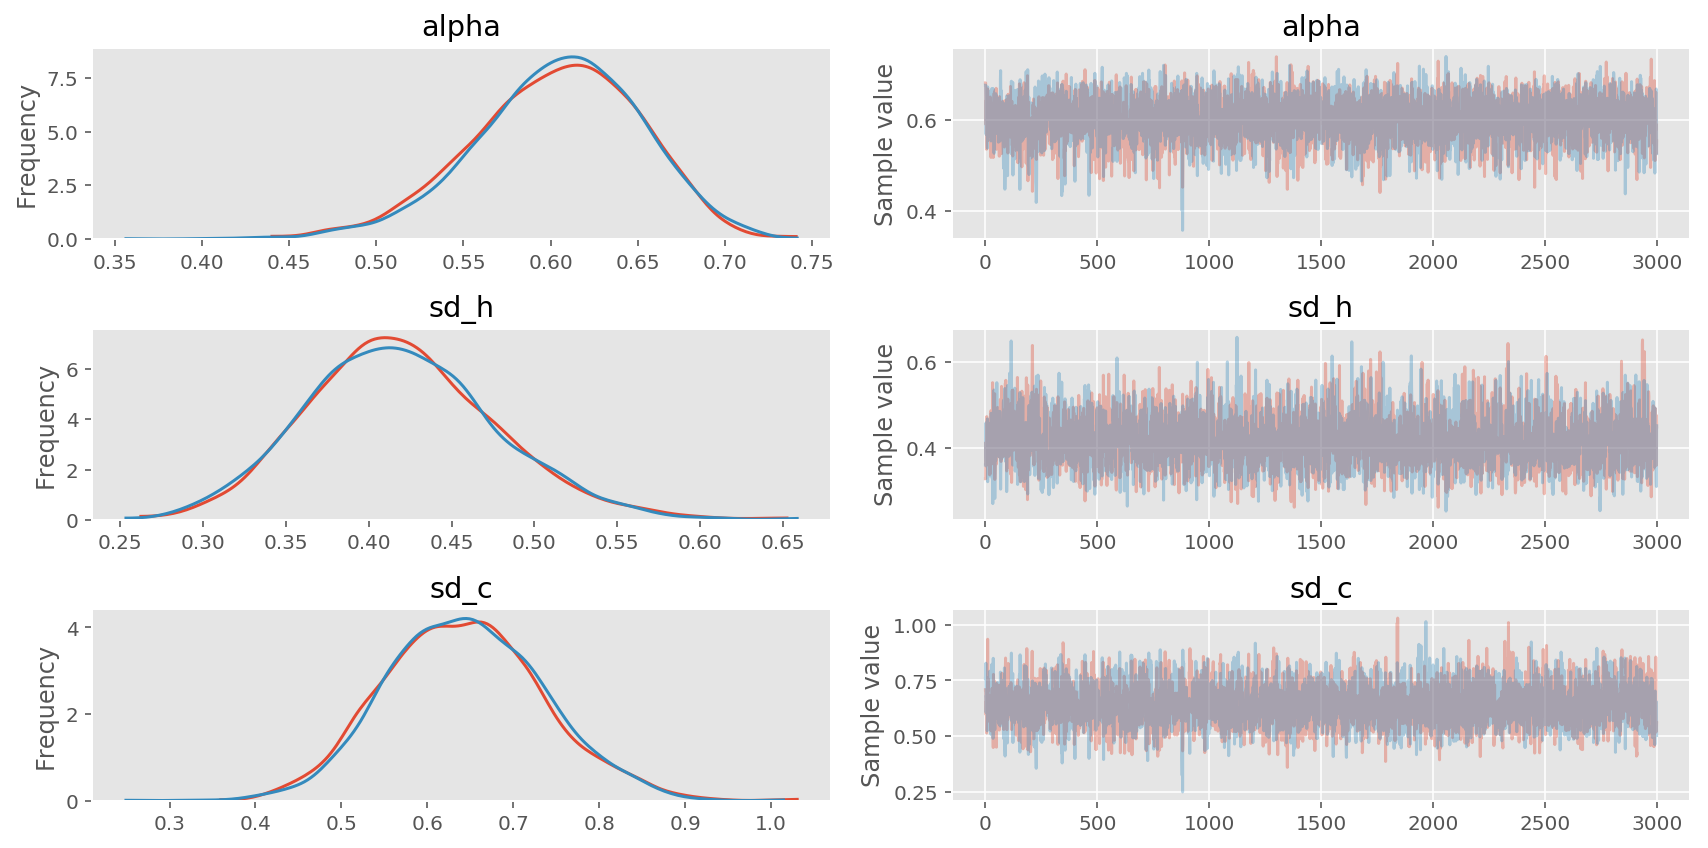

In [7]:
pm.traceplot(trace1, varnames=['alpha', 'sd_h', 'sd_c']);

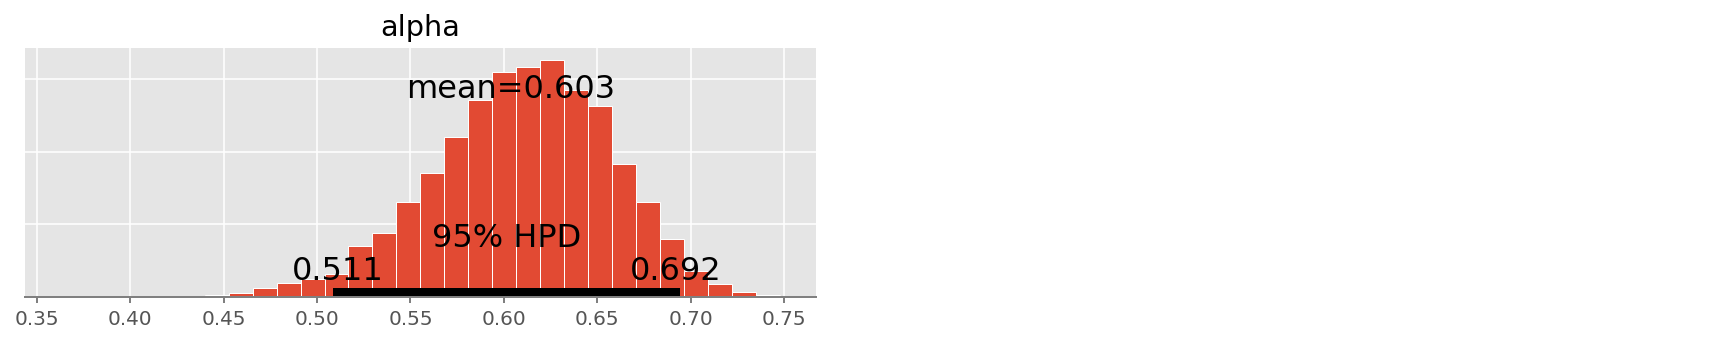

In [8]:
pm.plot_posterior(trace1, varnames=['alpha']);

`theano.scan` is much faster than using a python for loop, but it is still quite slow. One of the way to improve is to use linear algebra and matrix multiplication. In another word, we should try to find a way to use matrix multiplication instead of for-loop (if you have experience in using MATLAB, it is the same philosophy). In our case, we can totally do that.  

For a similar problem, you can also have a look of [my port of Lee and Wagenmakers' book](https://github.com/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3). For example, in Chapter 19, the STAN code use [a for loop to generate the likelihood function](https://github.com/stan-dev/example-models/blob/master/Bayesian_Cognitive_Modeling/CaseStudies/NumberConcepts/NumberConcept_1_Stan.R#L28-L59), and I [generate the matrix outside and use matrix multiplication etc](http://nbviewer.jupyter.org/github/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3/blob/master/CaseStudies/NumberConceptDevelopment.ipynb#19.1-Knower-level-model-for-Give-N) to archive the same purpose.  

## PyMC3 implementation using some matrix "trick"

Again, we try on some simulation data to make sure the implementation is correct.

In [9]:
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype='int32')
for i, a in enumerate(adj):
    amat2[i, a] = 1
    wmat2[i, a] = weights[i]

value = np.asarray(np.random.randn(N,), dtype=theano.config.floatX)

print(np.sum(value*amat2, axis=1)/np.sum(wmat2, axis=1))


def mu_phi(value):
    N = len(weights)
    # Calculate mu based on average of neighbours
    mu = np.array([np.sum(weights[i]*value[adj[i]])/Wplus[i] for i in range(N)])
    return mu

print(mu_phi(value))

[  4.72851002e-03  -3.04469723e-02   5.41328197e-01   7.40375578e-02
   6.22067155e-02   3.53464086e-01   2.17902136e-01   1.22560096e+00
  -1.57001257e-01   4.56155778e-01   4.25493319e-02   1.08399705e-01
   1.09115834e-02   1.05034514e-01  -1.54246912e-01   5.61784940e-01
   3.28490437e-01  -2.27265493e-01   4.64110608e-02  -1.46752608e-01
   4.04662801e-01   5.30307370e-01   2.81718432e-01   3.80404007e-02
   4.77864332e-01   1.56162457e-01  -2.94062164e-01   1.07509342e-04
  -1.18272199e-01   3.06665469e-01  -1.88346866e-02   5.54271790e-01
  -7.69124198e-03  -4.88672383e-01  -2.79492093e-01   4.15785838e-02
  -4.20684949e-01   1.93611559e-02  -6.82509482e-01   7.30231843e-02
  -5.11949160e-02   3.38524523e-01   5.70051335e-01   7.08699561e-01
   2.04210784e-01   1.31835923e-01  -1.80565441e-01   4.28414046e-01
  -2.71581234e-01   3.05553904e-01  -2.43524803e-01  -4.17353353e-01
  -4.12929153e-01  -6.66452987e-02   4.90242678e-01   1.97548165e-01]
[  4.72851002e-03  -3.04469723e-0

Now create a new CAR distribution with the matrix multiplication instead of `theano.scan` to get the `mu`

In [10]:
class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : adjacency matrix
    w : weight matrix
    tau : precision at each location
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a

        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [11]:
with pm.Model() as model2:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5)
    # Vague prior on covariate effect
    beta1 = pm.Normal('beta1', mu=0.0, tau=1.0e-5)

    # Random effects (hierarchial) prior
    tau_h = pm.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.Gamma('tau_c', alpha=1.0, beta=1.0)

    # Regional random effects
    theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=N)
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=tau_c, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(logE + beta0 + beta1*aff + theta + phi))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu, observed=O)

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))

    trace2 = pm.sample(3e3, njobs=2, tune=1000, nuts_kwargs={'max_treedepth': 15})

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 189.45: 100%|██████████| 200000/200000 [00:27<00:00, 7303.90it/s]
Finished [100%]: Average Loss = 189.42
100%|██████████| 3000/3000.0 [04:02<00:00, 14.20it/s]


**As you can see, its 6x faster using matrix multiplication.**

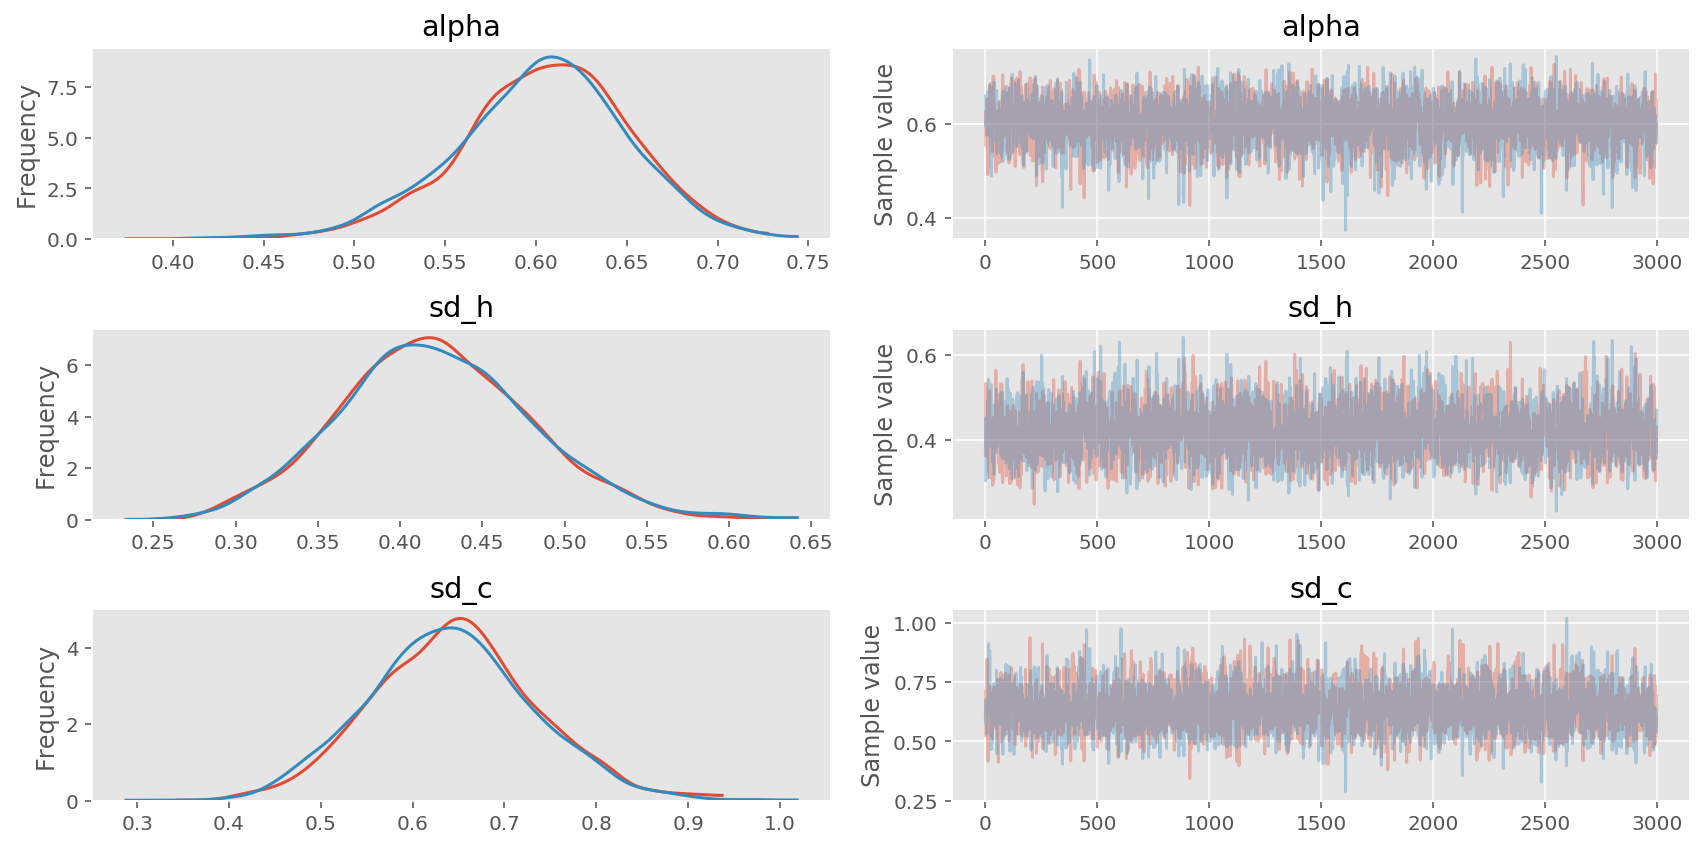

In [12]:
pm.traceplot(trace2, varnames=['alpha', 'sd_h', 'sd_c']);

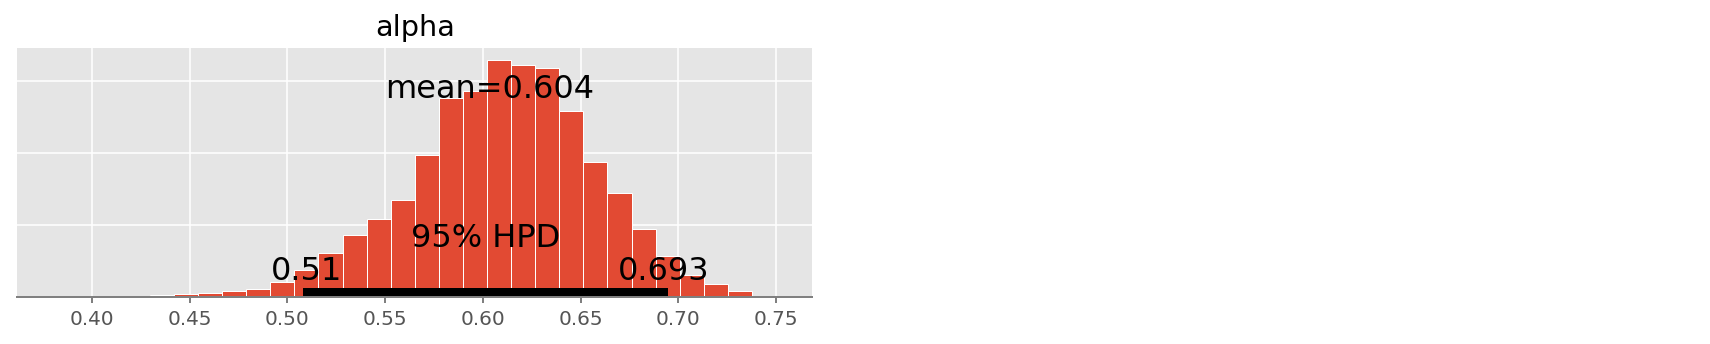

In [13]:
pm.plot_posterior(trace2, varnames=['alpha']);

## PyMC3 implementation using Matrix multiplication

There are (almost) always many ways to formulate your model. And some works better than the others under different context (size of your dataset, properties of the sampler, etc). In this case, we can expressed the CAR prior as:  

$$\phi \sim \mathcal{N}(0, [D_\tau (I - \alpha B)]^{-1}).$$

For the sake of brevity, you can find more details in the original [Stan case study](http://mc-stan.org/documentation/case-studies/mbjoseph-CARStan.html). You might come across similar deviation in Gaussian Process, which result in a zero-mean Gaussian distribution conditioned on a covariance function.

In the `Stan` Code, matrix D is generated in the model using a `transformed data{}` block:
```Stan
transformed data{
  vector[n] zeros;
  matrix<lower = 0>[n, n] D;
  {
    vector[n] W_rowsums;
    for (i in 1:n) {
      W_rowsums[i] = sum(W[i, ]);
    }
    D = diag_matrix(W_rowsums);
  }
  zeros = rep_vector(0, n);
}
```
We can generate the same matrix quite easily:

In [14]:
X = np.hstack((np.ones((N, 1)), stats.zscore(aff, ddof=1)[:, None]))
W = wmat2
D = np.diag(W.sum(axis=1))
log_offset = logE[:, None]

Then in the `STAN` model:
```stan
model {
  phi ~ multi_normal_prec(zeros, tau * (D - alpha * W));
  ...
} 
```
since the precision matrix just generated by some matrix multiplication, we can do just that in `PyMC3`:

In [15]:
with pm.Model() as model3:
    # Vague prior on intercept and effect
    beta = pm.Normal('beta', mu=0.0, tau=1.0, shape=(2, 1))

    # Priors for spatial random effects
    tau = pm.Gamma('tau', alpha=2., beta=2.)
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    phi = pm.MvNormal('phi', mu=0, tau=tau*(D - alpha*W), shape=(N, 1))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(tt.dot(X, beta) + phi + log_offset))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu.ravel(), observed=O)

    trace3 = pm.sample(3e3, njobs=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 171.81: 100%|██████████| 200000/200000 [02:44<00:00, 1219.39it/s]
Finished [100%]: Average Loss = 171.81
100%|██████████| 3000/3000.0 [01:39<00:00, 30.01it/s]


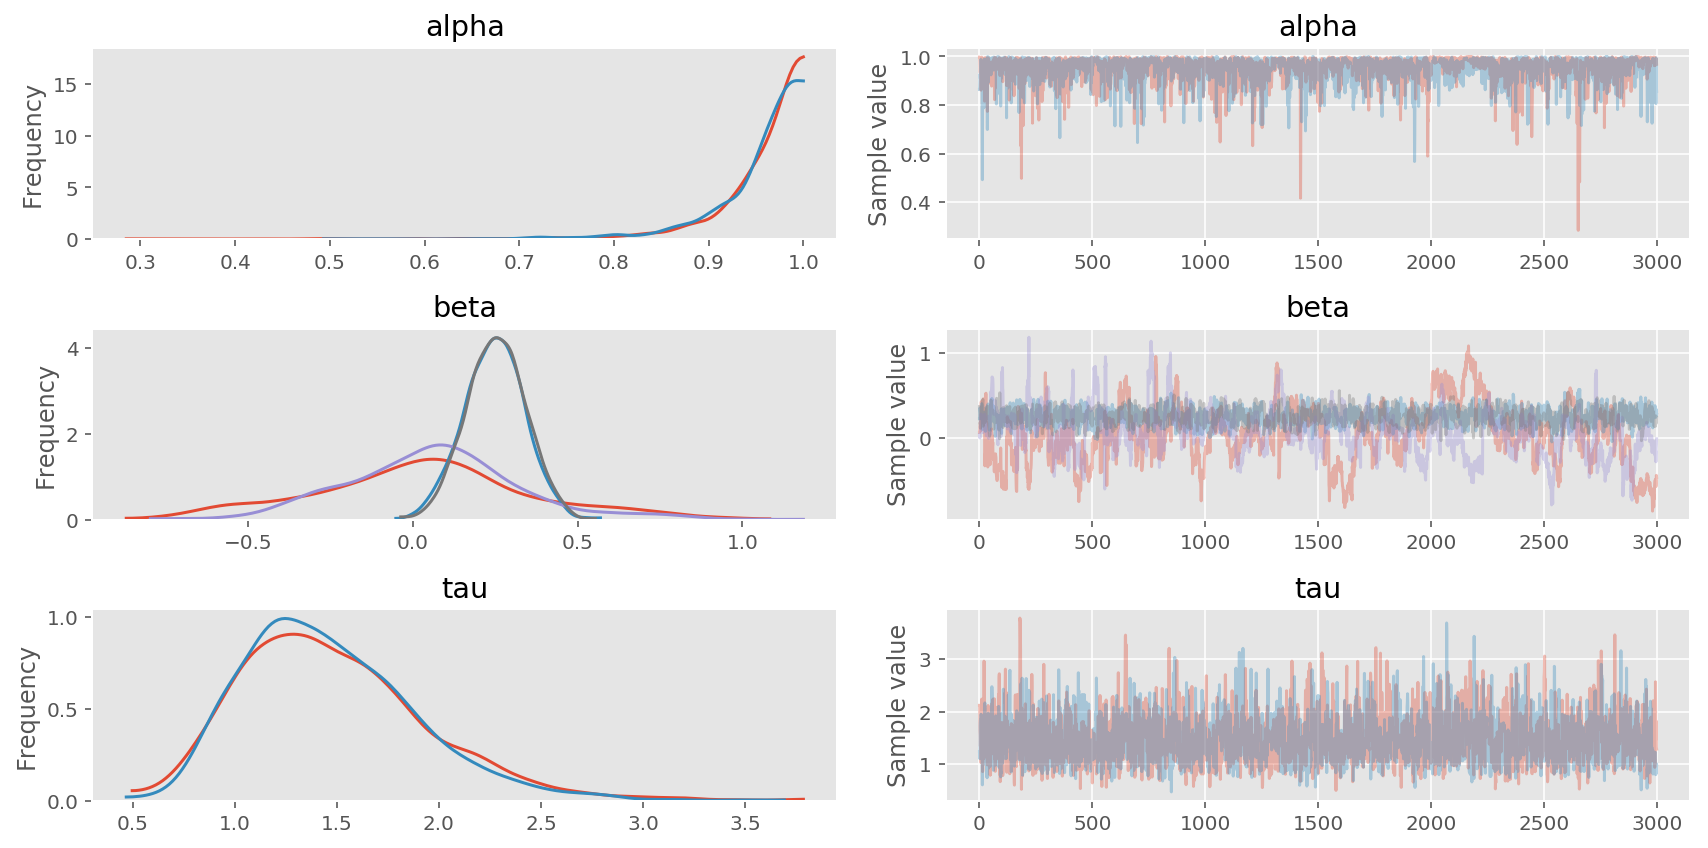

In [16]:
pm.traceplot(trace3, varnames=['alpha', 'beta', 'tau']);

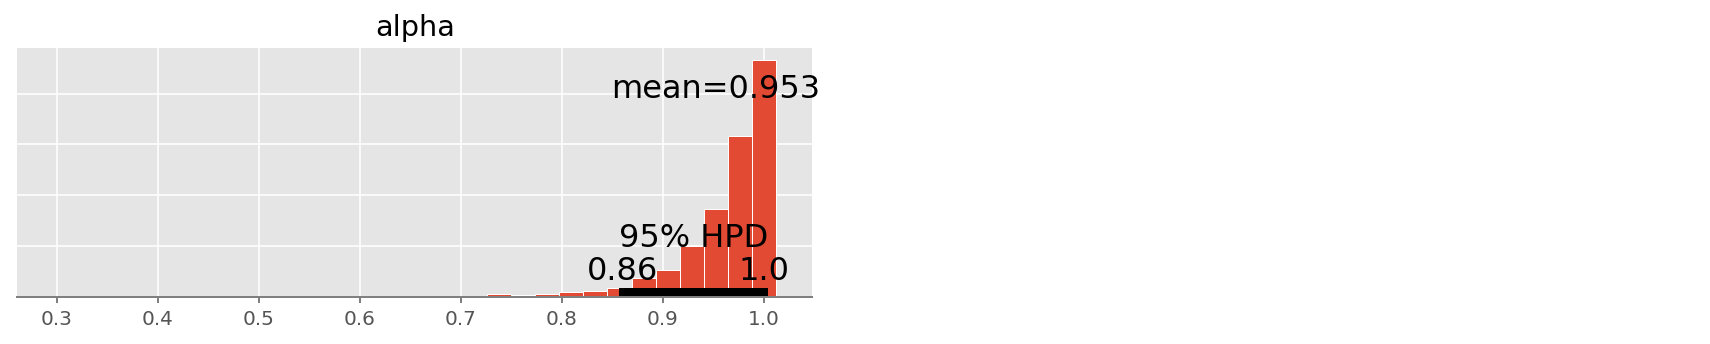

In [17]:
pm.plot_posterior(trace3, varnames=['alpha']);

Notice that since the model parameterization is different than in the `WinBugs` model, the `alpha` doesn't bear the same interpretation.

## PyMC3 implementation using Sparse Matrix

Note that in the node $\phi \sim \mathcal{N}(0, [D_\tau (I - \alpha B)]^{-1})$, we are computing the log-likelihood for a multivariate Gaussian distribution, which might not scale well in high-dimension. We can take advantage of the fact that the covariance matrix here $[D_\tau (I - \alpha B)]^{-1}$ is sparse, and there are faster ways to compute log-likelihood. 

For example, a more efficient sparse representation of the CAR in `STAN`:
```stan
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real tau, real alpha, 
    int[,] W_sparse, vector D_sparse, vector lambda, int n, int W_n) {
      row_vector[n] phit_D; // phi' * D
      row_vector[n] phit_W; // phi' * W
      vector[n] ldet_terms;
    
      phit_D = (phi .* D_sparse)';
      phit_W = rep_row_vector(0, n);
      for (i in 1:W_n) {
        phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
        phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
      }
    
      for (i in 1:n) ldet_terms[i] = log1m(alpha * lambda[i]);
      return 0.5 * (n * log(tau)
                    + sum(ldet_terms)
                    - tau * (phit_D * phi - alpha * (phit_W * phi)));
  }
}
```
with the data transformed in the model:
```stan
transformed data {
  int W_sparse[W_n, 2];   // adjacency pairs
  vector[n] D_sparse;     // diagonal of D (number of neigbors for each site)
  vector[n] lambda;       // eigenvalues of invsqrtD * W * invsqrtD
  
  { // generate sparse representation for W
  int counter;
  counter = 1;
  // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1:(n - 1)) {
      for (j in (i + 1):n) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1:n) D_sparse[i] = sum(W[i]);
  {
    vector[n] invsqrtD;  
    for (i in 1:n) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}
```
and the likelihood:
```stan
model {
  phi ~ sparse_car(tau, alpha, W_sparse, D_sparse, lambda, n, W_n);
}
```

There are quite a lot of codes to digest, my general approach is to compare the intermedia step whenever possible with `STAN`. In this case, I will try to compute `tau, alpha, W_sparse, D_sparse, lambda, n, W_n` outside of the `STAN` model in `R` and compare with my own implementation.  

Below is a Sparse CAR implementation in `PyMC3` ([see also here](https://github.com/pymc-devs/pymc3/issues/2066#issuecomment-296397012)). Again, we try to avoide using any for-loop as in `STAN`.

In [18]:
import scipy

class Sparse_CAR(distribution.Continuous):
    """
    Sparse Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    alpha : spatial smoothing term
    W : adjacency matrix
    tau : precision at each location
    """

    def __init__(self, alpha, W, tau, *args, **kwargs):
        self.alpha = alpha = tt.as_tensor_variable(alpha)
        self.tau = tau = tt.as_tensor_variable(tau)
        D = W.sum(axis=0)
        n, m = W.shape
        self.n = n
        self.median = self.mode = self.mean = 0
        super(Sparse_CAR, self).__init__(*args, **kwargs)

        # eigenvalues of D^−1/2 * W * D^−1/2
        Dinv_sqrt = np.diag(1 / np.sqrt(D))
        DWD = np.matmul(np.matmul(Dinv_sqrt, W), Dinv_sqrt)
        self.lam = scipy.linalg.eigvalsh(DWD)

        # sparse representation of W
        w_sparse = scipy.sparse.csr_matrix(W)
        self.W = theano.sparse.as_sparse_variable(w_sparse)
        self.D = tt.as_tensor_variable(D)

        # Presicion Matrix (inverse of Covariance matrix)
        # d_sparse = scipy.sparse.csr_matrix(np.diag(D))
        # self.D = theano.sparse.as_sparse_variable(d_sparse)
        # self.Phi = self.tau * (self.D - self.alpha*self.W)

    def logp(self, x):
        logtau = self.n * tt.log(tau)
        logdet = tt.log(1 - self.alpha * self.lam).sum()

        # tau * ((phi .* D_sparse)' * phi - alpha * (phit_W * phi))
        Wx = theano.sparse.dot(self.W, x)
        tau_dot_x = self.D * x.T - self.alpha * Wx.ravel()
        logquad = self.tau * tt.dot(x.ravel(), tau_dot_x.ravel())

        # logquad = tt.dot(x.T, theano.sparse.dot(self.Phi, x)).sum()
        return 0.5*(logtau + logdet - logquad)

In [19]:
with pm.Model() as model4:
    # Vague prior on intercept and effect
    beta = pm.Normal('beta', mu=0.0, tau=1.0, shape=(2, 1))

    # Priors for spatial random effects
    tau = pm.Gamma('tau', alpha=2., beta=2.)
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    phi = Sparse_CAR('phi', alpha, W, tau, shape=(N, 1))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(tt.dot(X, beta) + phi + log_offset))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu.ravel(), observed=O)

    trace4 = pm.sample(3e3, njobs=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 161.51: 100%|██████████| 200000/200000 [00:31<00:00, 6371.06it/s]
Finished [100%]: Average Loss = 161.51
100%|██████████| 3000/3000.0 [00:09<00:00, 329.12it/s]


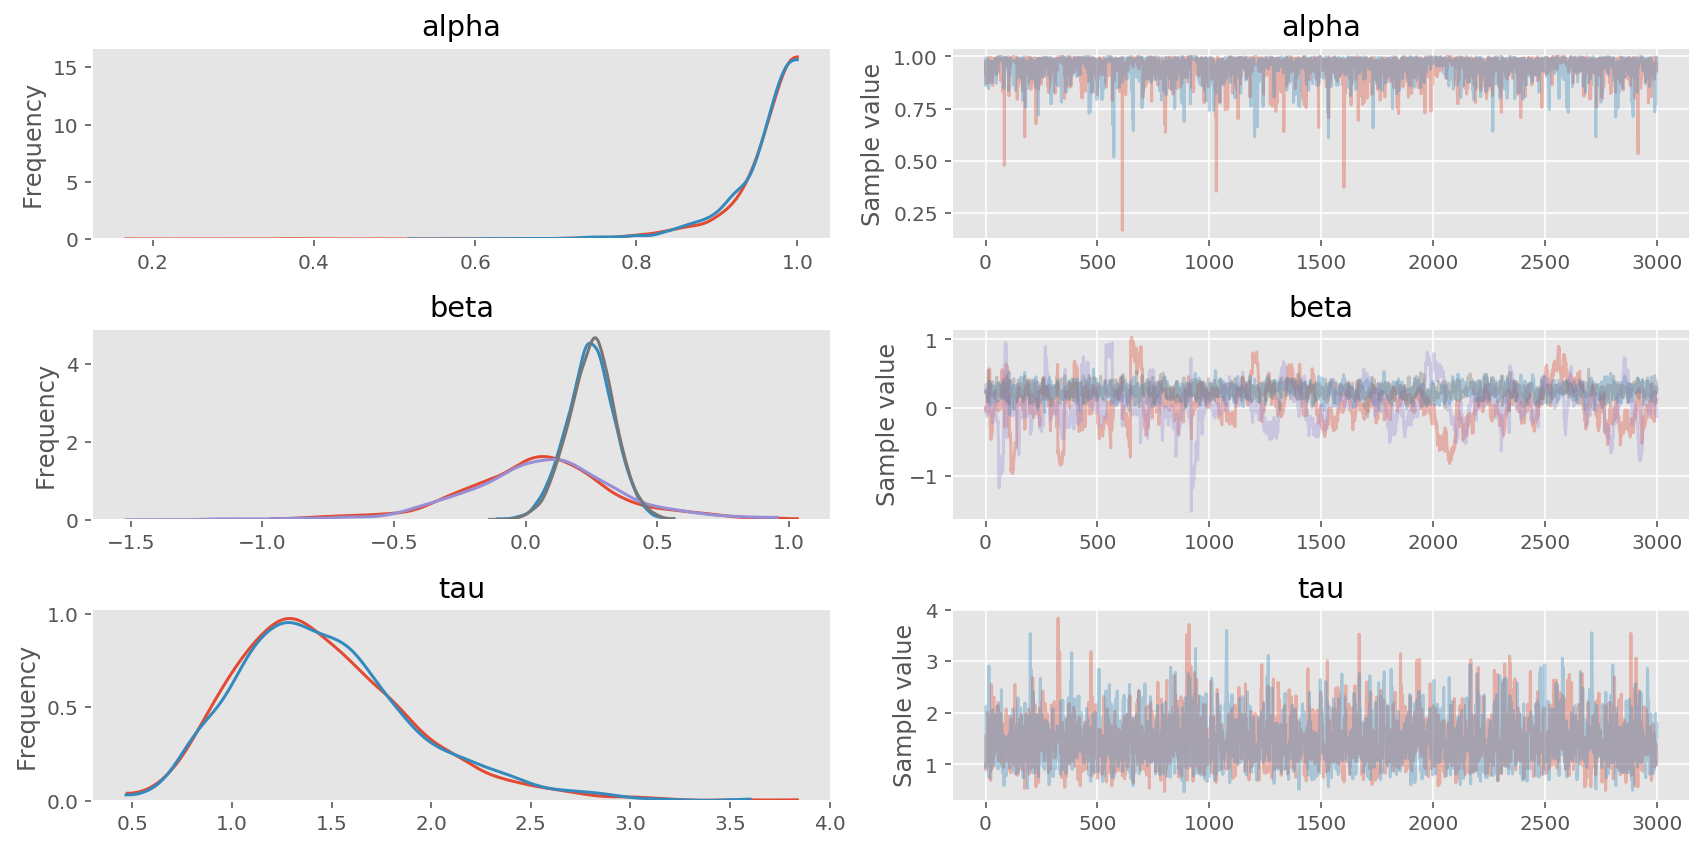

In [20]:
pm.traceplot(trace4, varnames=['alpha', 'beta', 'tau']);

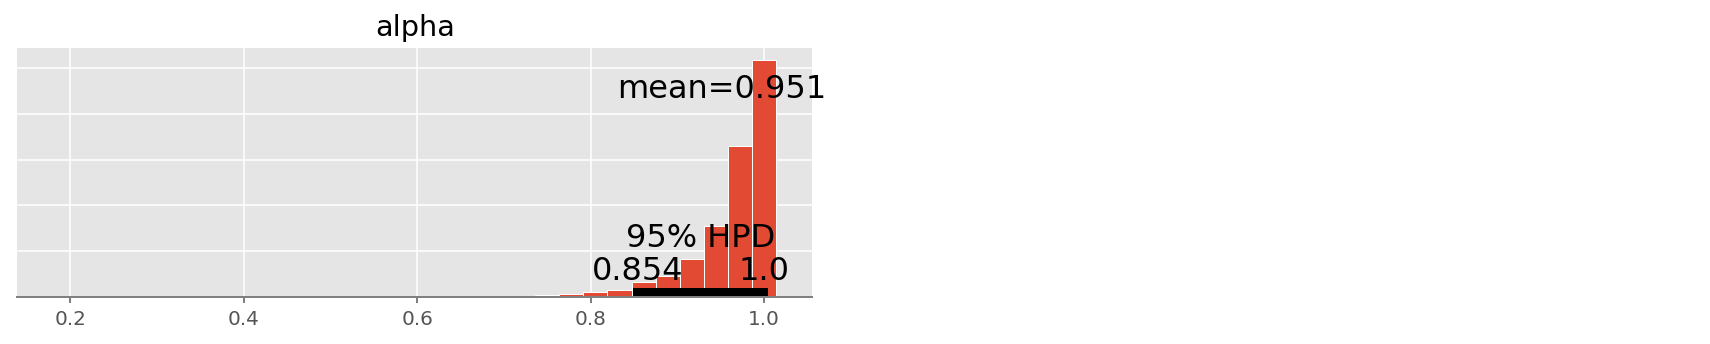

In [21]:
pm.plot_posterior(trace4, varnames=['alpha']);

As you can see above, the sparse representation returns the same estimation, while being much faster than any other implementation. 

## Final remarks

In this notebook, most of the parameter conventions (e.g., using `tau` when defining a Normal distribution) and choice of priors are strictly matched with the original code in `Winbugs` or `Stan`. However, it is important to note that merely porting the code from one to the other is not always the best practice. The aims are not just to run the code in `PyMC3`, but to make sure the model is appropriate as it returns correct estimation, and runs efficiently (fast sampling). 

For example, as [@aseyboldt](https://github.com/aseyboldt) pointed out [here](https://github.com/pymc-devs/pymc3/pull/2080#issuecomment-297456574) and [here](https://github.com/pymc-devs/pymc3/issues/1924#issue-215496293), non-centered parametrizations are often a better choice than the centered parametrizations. In our case here, `phi` is following a zero-mean Normal distribution, thus it can be leaved out in the beginning and just scale the values afterwards. In many cases doing this can avoids correlations in the posterior (it will be slower in some cases, however).  

Another thing to keep in mind is that sometimes your model is sensitive to prior choice: for example, you can have a bad experiences using Normals with a large sd as prior. Gelman often recommends Cauchy or StudentT, and more heuristic on prior could be found on the [Stan wiki](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations).  

There are always ways to improve (tidy up the code, more careful on the matrix multiplication, etc,.). Since our computational graph under `pm.Model()` are all `theano` objects, we can always do `print(VAR_TO_CHECK.tag.test_value)` right after the declaration or computation to check the shape. 
For example, in our last example, as suggested by [@aseyboldt](https://github.com/pymc-devs/pymc3/pull/2080#issuecomment-297456574) there seem to be a lot of correlations in the posterior. That probably slows down NUTS quite a bit. As a debugging tool and guide for reparametrization you can look at the singular value decomposition of the standardized samples from the trace – basically the eigenvalues of the correlation matrix. If the problem is high dimensional you can use stuff from `scipy.sparse.linalg` to only compute the largest singular value:  
```python
from scipy import linalg, sparse

vals = np.array([model.dict_to_array(v) for v in trace[1000:]]).T
vals[:] -= vals.mean(axis=1)[:, None]
vals[:] /= vals.std(axis=1)[:, None]

U, S, Vh = sparse.linalg.svds(vals, k=20)
```

Then look at `plt.plot(S)` to see if any principal components stick out, and check which variables are involved by looking at the singular vectors: `plt.plot(U[:, -1] ** 2)`. You can get the indices by looking at `model.bijection.ordering.vmap`.

Another great way to check the correlations in the posterior is to do a pairplot of the posterior (if your model doesn't contain too many parameters). You can see quite clearly if and where the the posterior parameters are correlated.

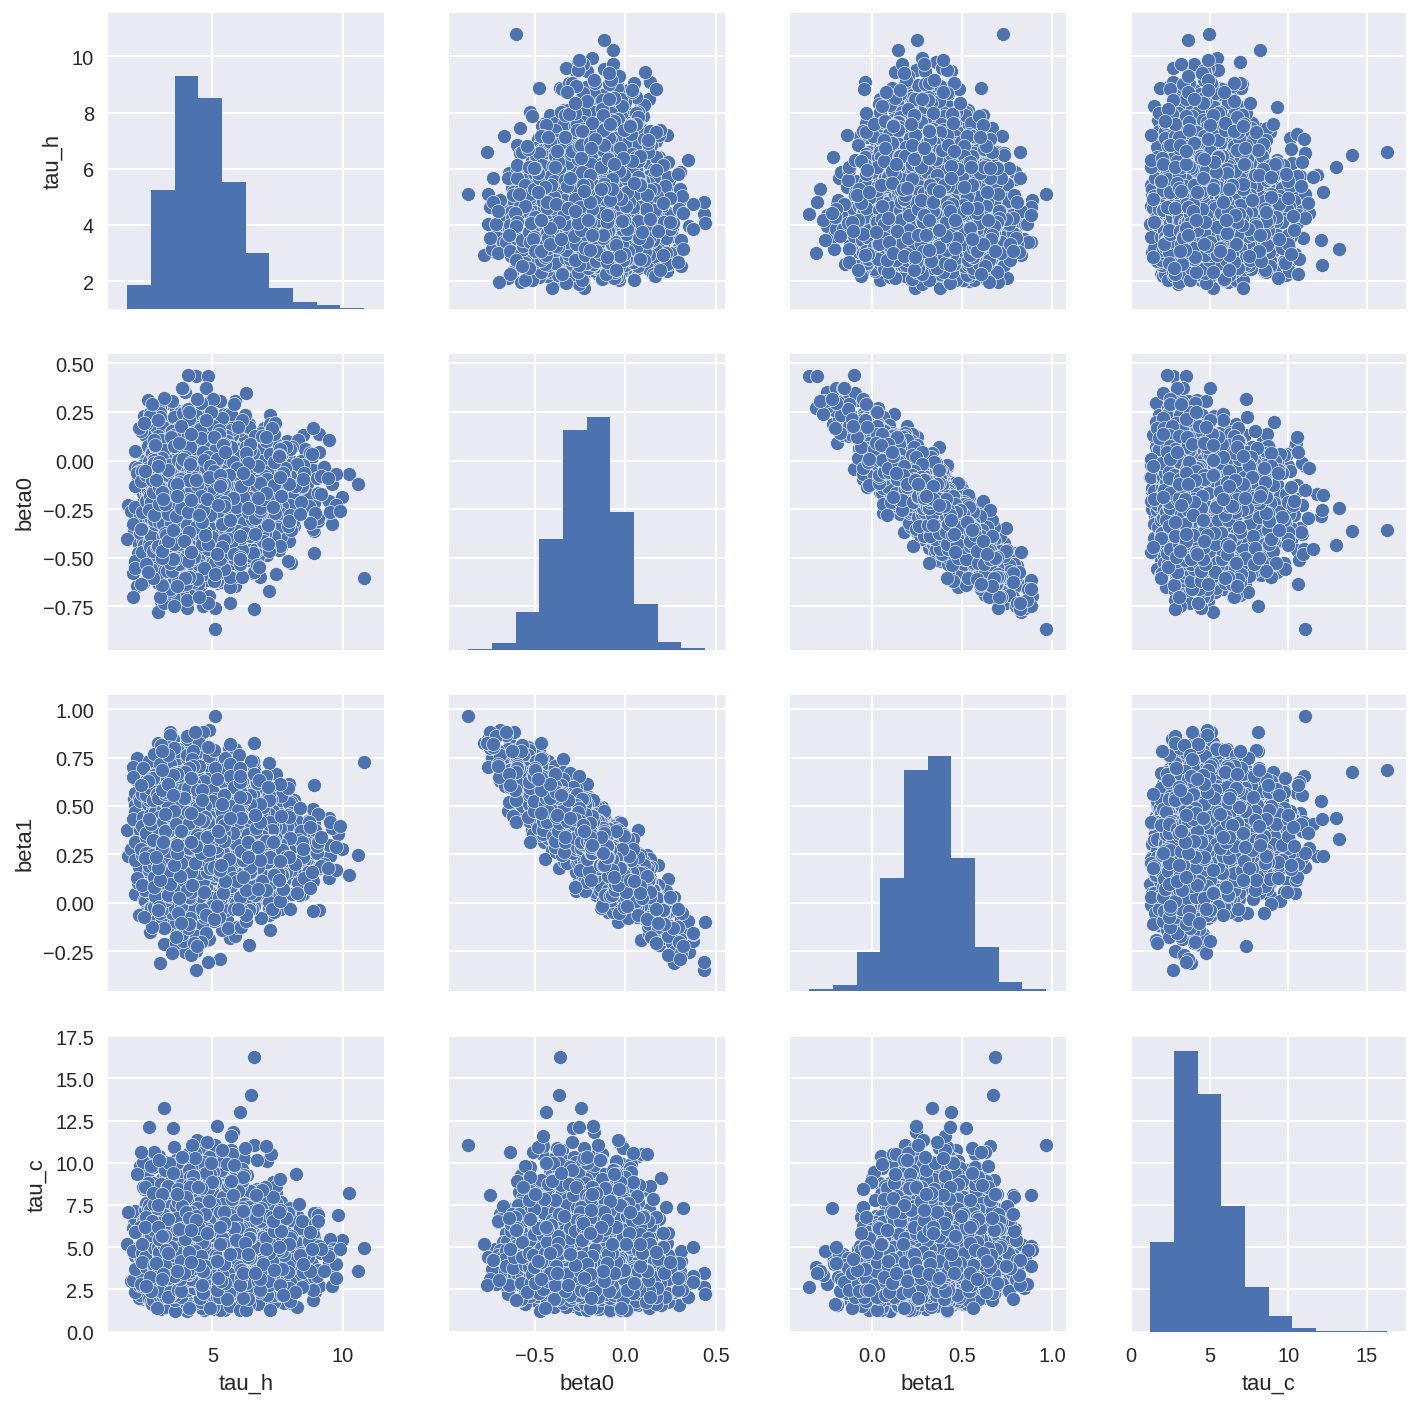

In [22]:
import seaborn as sns
tracedf1 = pm.trace_to_dataframe(trace1, varnames=['beta0', 'beta1', 'tau_h', 'tau_c'])
sns.pairplot(tracedf1);

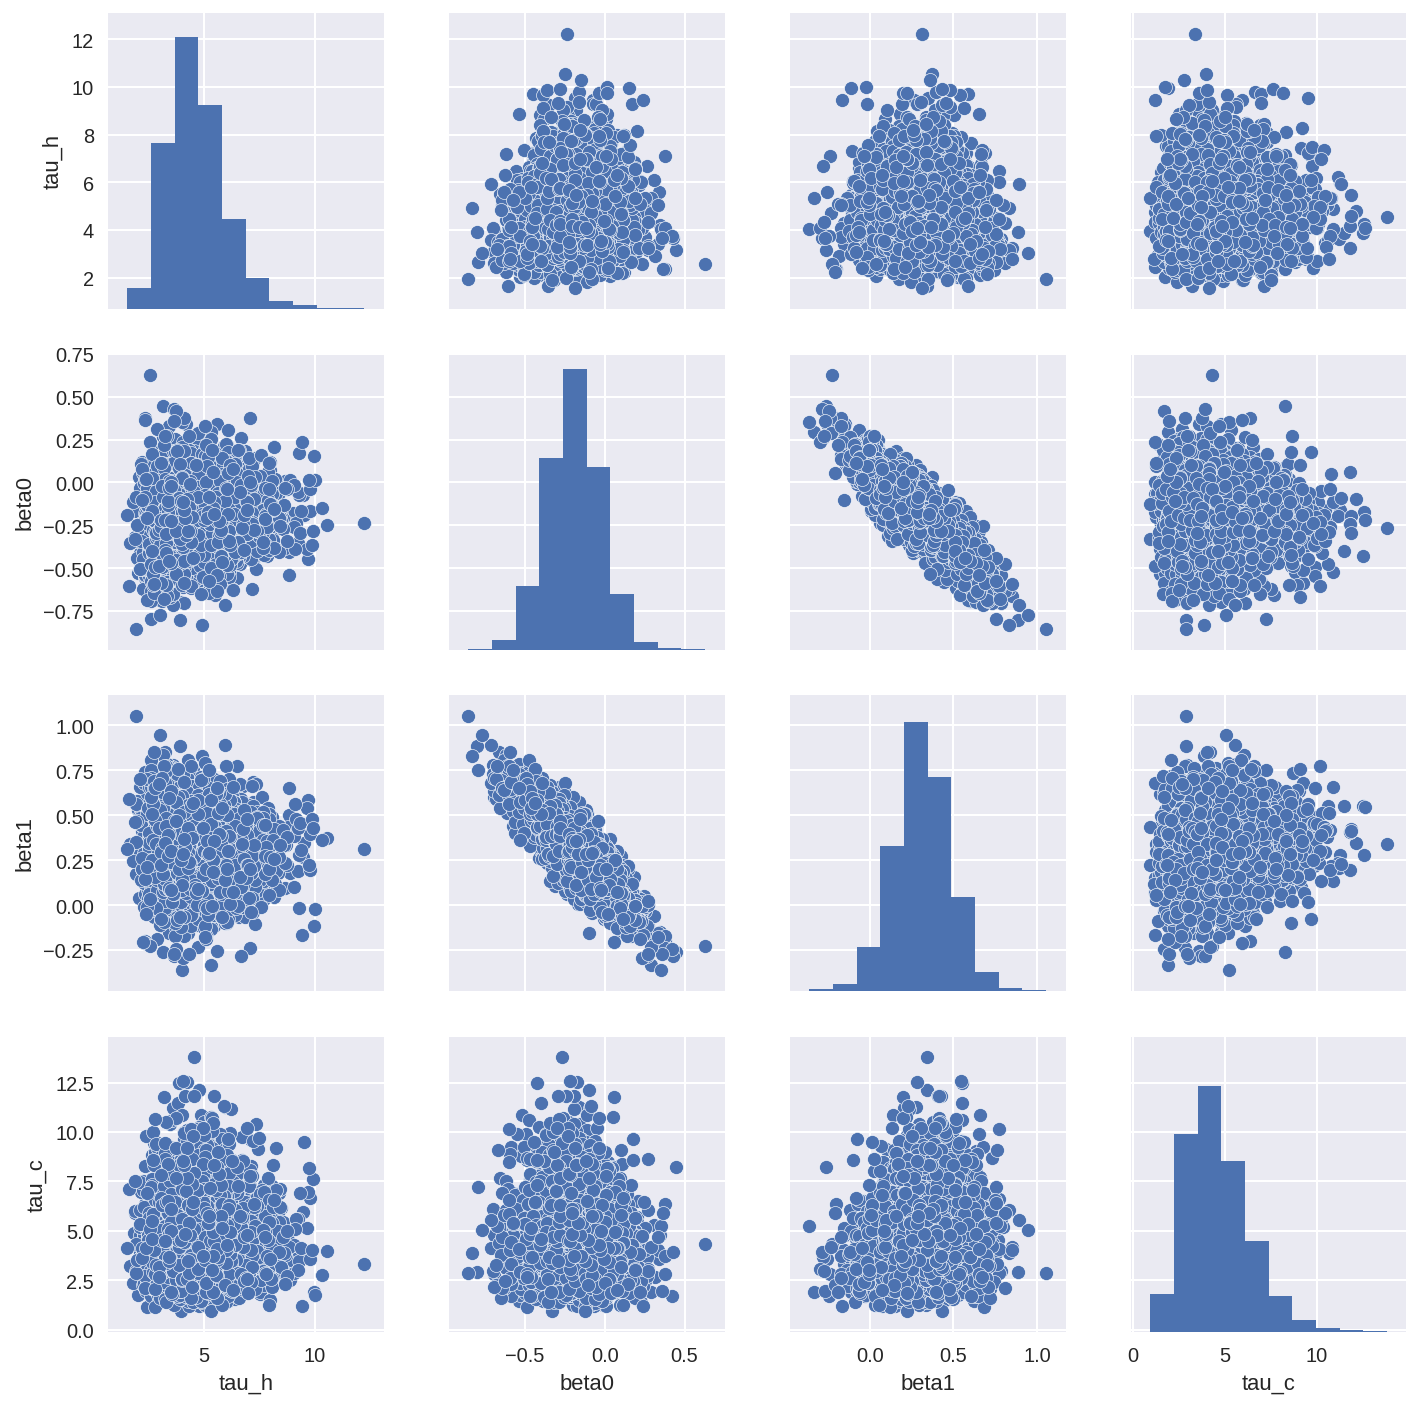

In [23]:
tracedf2 = pm.trace_to_dataframe(trace2, varnames=['beta0', 'beta1', 'tau_h', 'tau_c'])
sns.pairplot(tracedf2);

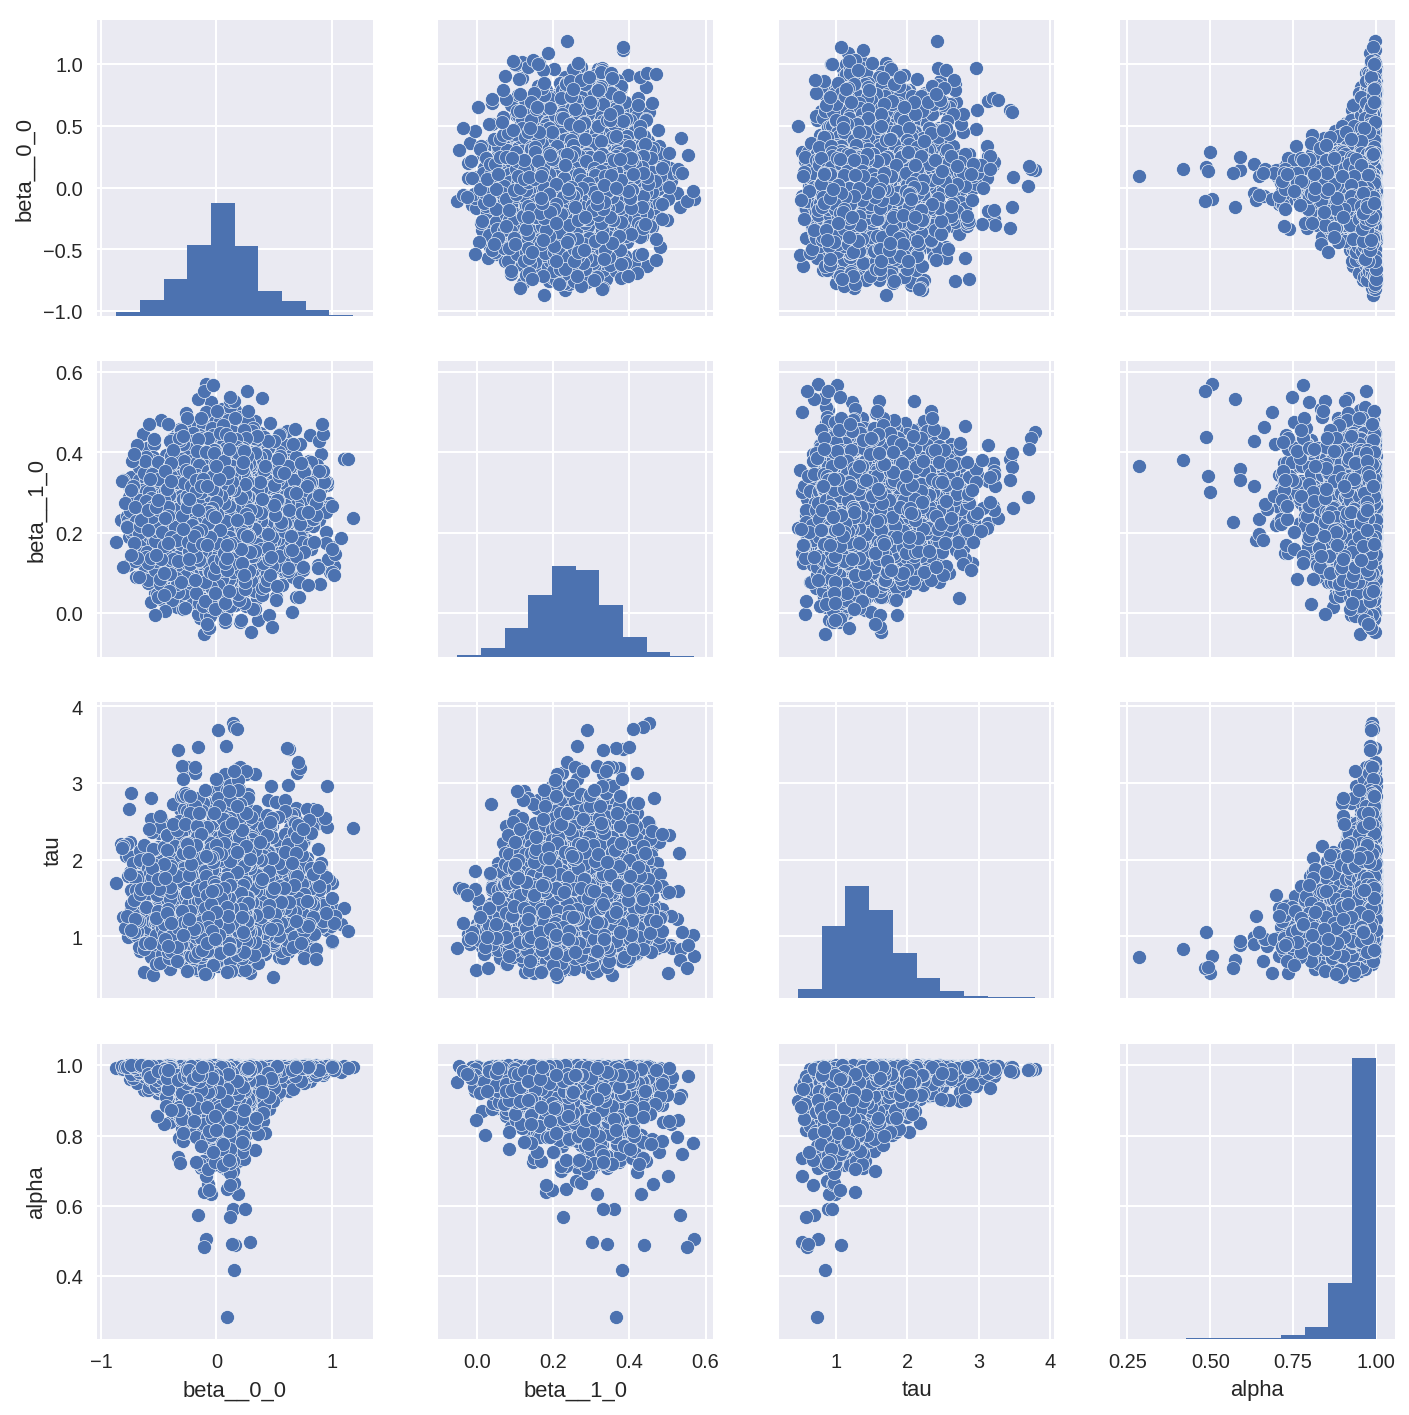

In [24]:
tracedf3 = pm.trace_to_dataframe(trace3, varnames=['beta', 'tau', 'alpha'])
sns.pairplot(tracedf3);

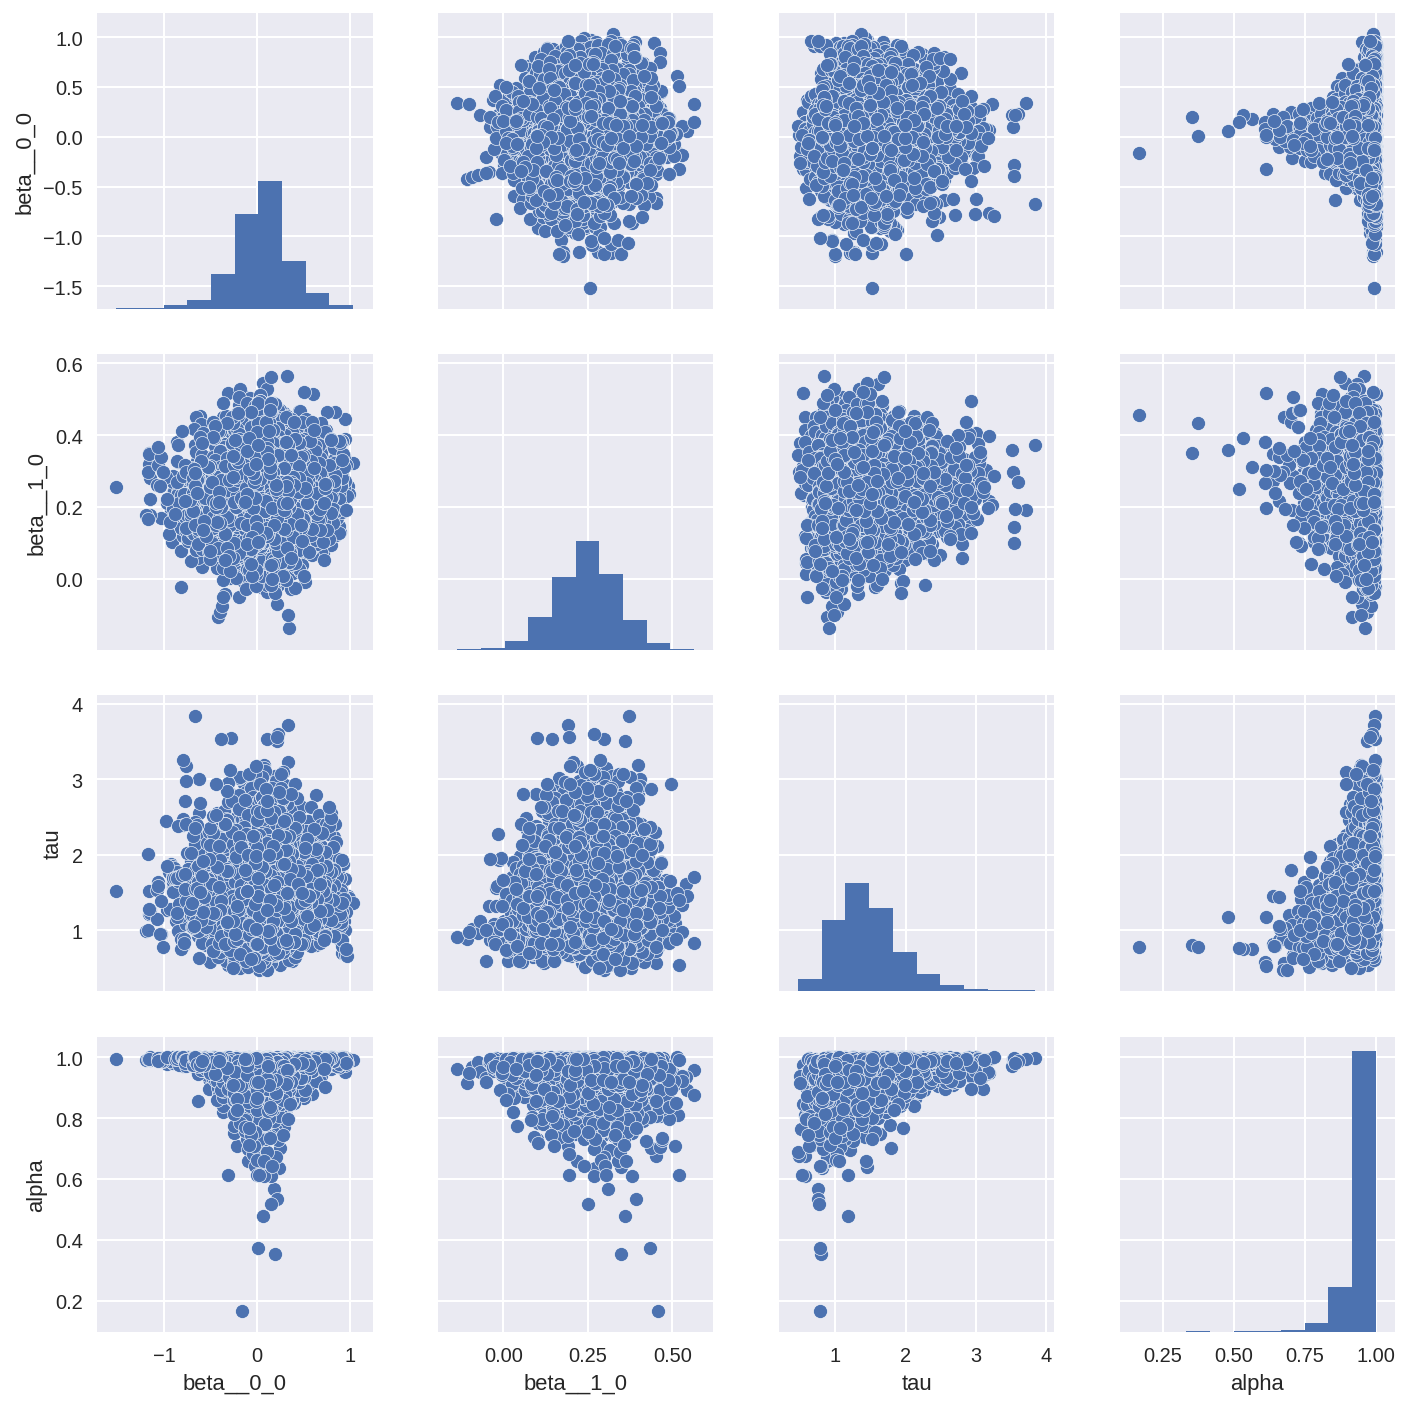

In [25]:
tracedf4 = pm.trace_to_dataframe(trace4, varnames=['beta', 'tau', 'alpha'])
sns.pairplot(tracedf4);